# Sequence to Sequence Model 
This project aims to generate informal Japanese to formal Japanese (Keigo). Although I am holding N1 Japanese-Language Proficiency Test, it is still difficult for me to write in formal Japanese (Keigo). This thought inspires me to start this project. Before I started the project, I saw this [wordrabbit company](https://wordrabbit.jp/) that does exactly what this project is aiming to do and plus correcting grammars. The company name is provided as a reference. 

There are mutiple sites and code examples that support me to build this model: 
* [bentrevett/pytorch-seq2seq](https://github.com/bentrevett/pytorch-seq2seq/blob/main/1%20-%20Sequence%20to%20Sequence%20Learning%20with%20Neural%20Networks.ipynb) -> most of the reference is from here for seq2seq model
* [NLP From Scratch: Translation with a Sequence to Sequence Network and Attention](https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html#loading-data-files)
* [日本語テキストの前処理：neologdn、大文字小文字、Unicode正規化](https://tuttieee.hatenablog.com/entry/ja-nlp-preprocess)
* [Hironsan/natural-language-preprocessings](https://github.com/Hironsan/natural-language-preprocessings/blob/master/preprocessings/ja/cleaning.py)
* [社会的関係を考慮した日本語敬語コーパスの構築への取り組み](https://www.jstage.jst.go.jp/article/pjsai/JSAI2022/0/JSAI2022_2C1GS601/_article/-char/ja/)
* [敬語変換タスクにおける評価用データセット](https://github.com/cl-tohoku/keigo_transfer_task?tab=readme-ov-file)

Also, if you want to make a reference to this code, please feel free to do so. HOWEVER, **rememeber to read the conclusion section before you refer to this project**.

*Disclaimer: this is for personal project (self-improvement) only, not for commercial use.*  

## Prerequisite
The following cell contains all the libraries you need to run this project. If any of this doesn't work, you can refer to the next two cell blocks which help you with the software setup. Two types of setup are available - iOS and Google Colab. Both installations are through pip. If any of the import failed above, use the corresponding command line to install. 

*   [MeCab](https://pypi.org/project/mecab-python3/)
*   [neologdn](https://pypi.org/project/neologdn/)
*   [evaluate](https://pypi.org/project/evaluate/)

*Note that this all use pip to install. If you want to use other method, you have to look it up.*


In [1]:
import MeCab # morphological analyzer
import re
import csv
import neologdn # Japanese text normalizer
import requests # handles url tasks
import torch
import torch.nn as nn
import torch.optim as optim
import spacy
import pandas as pd
import torchtext
import evaluate
# from torchtext.data import Field, BucketIterator, TabularDataset
from sklearn.model_selection import train_test_split
from torchtext.vocab import build_vocab_from_iterator
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu
from matplotlib import pyplot as plt
import numpy as np

/Users/eva.lee/Library/Python/3.11/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
# iOS
# pip3 install -U scikit-learn
# pip3 install torch torchvision torchaudio
# pip3 install pandas
# pip3 install torchtext
# pip3 install evaluate
# pip3 install matplotlib

In [7]:
# Google Colab
# %pip install mecab-python3
# %pip install unidic-lite
# %pip install langdetect
# %pip install -U deep-translator
# %pip install neologdn
# %pip install --user -U nltk
# %pip install spacy_download
# %pip install evaluate
# %pip install nltk
# !python3 -m spacy download ja_core_news_sm


## Retrive Data 
Data is retrive from a csv file. This created database is mostly coming from [日本語学習者支援のための敬語変換タスクの提案](https://github.com/cl-tohoku/keigo_transfer_task?tab=readme-ov-file). I have also contributed part of the dataset to increase the volumn of the database. 

Dataset [日本語学習者支援のための敬語変換タスクの提案](https://github.com/cl-tohoku/keigo_transfer_task?tab=readme-ov-file) was formed by Touhouky University to study keigo translation. The first column is original sentence - which could be either informal or formal (keigo); The second column is formal (keigo) sentences; The third column is the notation of the translation that indicates the level of transformation from original sentence to formal (keigo) sentence. The third column is not used in this project, because knowing the level of transformation is not the goal of the project. 

For the sentences I contributed to the database, I grabbed the sentences from newspapers and articles, asked ChatGPT to translate, then reviewed and edited the sentences myself.  

In total, there is **~850 data** in the csv file. This is not a lot of data, but this is the only open source dataset I could find at the moment. 

In [2]:
def reader():
    original_sen = []
    transform_sen = []

    with open('dataset.csv') as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        counter = 0

        for row in csv_reader:
            if len(row)==2 or (counter != 0): 
                original_sen.append(row[0])
                transform_sen.append(row[1])
            counter+=1

    return (original_sen, transform_sen)

def list_to_file(x, y, type):
    df = pd.DataFrame({'X_' + type: x, 'y_' + type: y})
    filename = type + '_data.csv'
    df.to_csv(filename) # overwrites everytime


## Data Preprocessing 
The data preprocessing has 3 parts: 
* **Data Cleaning**: removes the unneeded, corrupted notation in the given sentence. 
* **Normalization**: removes any numbers in the given sentence. 
* **Tokenization** : makes given sentence into segments of text in a meaningful way. I tried 2 kinds of tokenization library - spacy and [MeCab](https://taku910.github.io/mecab/). [MeCab](https://taku910.github.io/mecab/) gives a better meaningful segments, so I chose to use [MeCab](https://taku910.github.io/mecab/) instead of popular spacy library. In this Tokenization process, I also included `<sos>` and `<eos>` when tokens are made for each sentence. 

Other data preprocessing method doesn't make sense to apply for this project / dataset. For example, *Stop Words Removal* method is not used, because Japanese language doesn't really have any stop words. *Lemmatization* method does not apply either, because we are evaluating the transformation of informal Japanese to formal (keigo) Japanese. 

In [3]:
# Data Cleaning 
def data_cleaning(text):
    text = text.replace("\"", "") # remove double quote
    text = re.sub("[\uFF01-\uFF0F\uFF1A-\uFF20\uFF3B-\uFF40\uFF5B-\uFF65\u3000-\u303F\u2460-\u2473]", "", text) # remove special characters
    text = neologdn.normalize(text) # this includes a lot of special characters removal
    text = text.lower()
    return text

# Normalization 
def normalization(text):
    text = re.sub(r"\d+", "0", text) # delete numbers (set to 0)
    return text

def data_preprocessing(data_list): 
    preprocessed_data = [] 
    
    for data in data_list:
        print("\nbefore:", data)
        cleaned_data = data_cleaning(data)
        normalized_data = normalization(cleaned_data)
        print("after:", normalized_data)
        
        preprocessed_data.append(normalized_data)
        
    
        # tokens = [sos_token] + tokenization(normalized_data) + [eos_token]# tokenization
        # print("Token:" ,tokens)

        # vacab = torchtext.vocab.build_vocab_from_iterator(tokens)
        # print(vacab.get_itos())
        # tokenization_spacy(normalized_data)

    return preprocessed_data 


In [4]:
# Tokenization
def tokenization(text):
    wakati = MeCab.Tagger("-Owakati")
    tokenized_data = wakati.parse(text).split()
    return tokenized_data

# Tokenization with Spacy
def tokenization_spacy(text):
    nlp = spacy.load("ja_core_news_sm") # Spacy's trained pipeline for Japanese - Language Object
    tokenized_data = []
    for token in nlp.tokenizer(text):
        tokenized_data.append(token)
    return nlp.tokenizer(text)

# Accepts a list of strings (sentences) to do tokenization 
def token_generator(text_list, sos_token, eos_token):
    for text in text_list:
        yield [sos_token] + tokenization(text) + [eos_token]
        

### Simple Example
This is example with both x (informal) and y (formal) data. 

In [5]:
sentence_4 = "週末街に出た"
sentence_4_trg = "週末街に出てきました"

In [7]:
X_train_sample = [sentence_4]
y_train_sample = [sentence_4_trg]

sos_token = "<sos>"
eos_token = "<eos>"

preprocessed_x_sample = data_preprocessing(X_train_sample) 
preprocessed_y_sample = data_preprocessing(y_train_sample) 

tokenized_x_sample = token_generator(preprocessed_x_sample, sos_token, eos_token)# tokenization
tokenized_y_sample = token_generator(preprocessed_y_sample, sos_token, eos_token)# tokenization


before: 週末街に出た
after: 週末街に出た

before: 週末街に出てきました
after: 週末街に出てきました


### Simple Example 2
I pulled out some sentences from the dataset to show how the data preprocessing is done for better understanding.  


In [8]:
example = "朝ごはんはトーストにバターとべジマイトを薄くぬって食べました。"
example_2 = "お医者さんに会ったけど彼は「あなたは元気ですが、ティーンエイジャーだからいつも眠いのですね。」と言いました。"
example_3 = "①中国の漁船が日本の海上保安庁の船に故意に激突（これについては証拠のビデオがあるそうです）"
example_4 = "ちなみに、台湾の人気ウェブは\"台灣論壇\"や\"台大PTT(BBS)\"です。"
example_5 = "Ｐａｌｍ　Ｓｐｒｉｎｇｓでは　沢山のＲｅｓｏｒｔが　あります。"
example_6 = "明日、友達と一緒に町へ行ってきます。もっとネイルチップがほしいです（笑）。"
example_7 = "神様だけが知っている、秘密～～～～♫　あはははっははははははっははははｋｋｋｋｋｋｋｋｋｋｋｋｋｋｋｋｋｋｋｋｋｋｋｋｋｋｋｋ"
example_8 = "東京部の最低賃金は１時間で７９１円だが、アメリカは１時間で７．２５ドルだ 。"
example_9 = "だから私は Manga Moods と呼ばれる別の本を借りました。"
example_9 = "だから私は Manga Moods と呼ばれる別の本を借りました。"


In [9]:
# Data preprocessing with some samples
X_train = [example, example_2, example_3, example_4, example_5,
        example_6, example_7, example_8, example_9]

preprocessed_data = [] 
sos_token = "<sos>"
eos_token = "<eos>"

for text in X_train:
    tokenization_spacy(text)
 
preprocessed_data = data_preprocessing(X_train) # # accepts a list of strings (sentences) to do data preprocessing

# print("\nPreprocessed_data:" , preprocessed_data)

tokenized_data = token_generator(preprocessed_data, sos_token, eos_token) # accepts a list of strings (sentences) to do tokenization
# print("\ntokenized_data:" , tokenized_data)



before: 朝ごはんはトーストにバターとべジマイトを薄くぬって食べました。
after: 朝ごはんはトーストにバターとべジマイトを薄くぬって食べました

before: お医者さんに会ったけど彼は「あなたは元気ですが、ティーンエイジャーだからいつも眠いのですね。」と言いました。
after: お医者さんに会ったけど彼はあなたは元気ですがティーンエイジャーだからいつも眠いのですねと言いました

before: ①中国の漁船が日本の海上保安庁の船に故意に激突（これについては証拠のビデオがあるそうです）
after: 中国の漁船が日本の海上保安庁の船に故意に激突これについては証拠のビデオがあるそうです

before: ちなみに、台湾の人気ウェブは"台灣論壇"や"台大PTT(BBS)"です。
after: ちなみに台湾の人気ウェブは台灣論壇や台大ptt(bbs)です

before: Ｐａｌｍ　Ｓｐｒｉｎｇｓでは　沢山のＲｅｓｏｒｔが　あります。
after: palmspringsでは沢山のresortがあります

before: 明日、友達と一緒に町へ行ってきます。もっとネイルチップがほしいです（笑）。
after: 明日友達と一緒に町へ行ってきますもっとネイルチップがほしいです笑

before: 神様だけが知っている、秘密～～～～♫　あはははっははははははっははははｋｋｋｋｋｋｋｋｋｋｋｋｋｋｋｋｋｋｋｋｋｋｋｋｋｋｋｋ
after: 神様だけが知っている秘密♫あはははっははははははっははははkkkkkkkkkkkkkkkkkkkkkkkkkkkk

before: 東京部の最低賃金は１時間で７９１円だが、アメリカは１時間で７．２５ドルだ 。
after: 東京部の最低賃金は0時間で0円だがアメリカは0時間で0ドルだ

before: だから私は Manga Moods と呼ばれる別の本を借りました。
after: だから私はmanga moodsと呼ばれる別の本を借りました


### Dataset Preprocessing
This section uses the same method to do data preprocessing for dataset. 


In [10]:
original_sen, transform_sen = reader() # get dataset 

X_train, X_test, y_train, y_test = train_test_split(original_sen, transform_sen, test_size = 0.2, random_state = 0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = 0)

sos_token = "<sos>"
eos_token = "<eos>"

preprocessed_x = data_preprocessing(X_train) 
preprocessed_y = data_preprocessing(y_train)

preprocessed_x_val = data_preprocessing(X_val) 
preprocessed_y_val = data_preprocessing(y_val)

preprocessed_x_test = data_preprocessing(X_test) 
preprocessed_y_test = data_preprocessing(y_test)

tokenized_x = token_generator(preprocessed_x, sos_token, eos_token)# tokenization
tokenized_y = token_generator(preprocessed_y, sos_token, eos_token)# tokenization


# store train and test data into csv file for better visualization
list_to_file(preprocessed_x, preprocessed_y, "train")
list_to_file(preprocessed_x_val, preprocessed_y_val, "test")
list_to_file(preprocessed_x_test, preprocessed_y_test, "validate")


# train_data = [] # a list of dictionary

# for i in range(len(preprocessed_x)):
#     each_train_data = {} # each train data info is stored in a dict

#     # preprocess the informal Japanese
#     original_sen[i] = data_cleaning(original_sen[i])
#     original_sen[i] = normalization(original_sen[i]) # string

#     # # preprocess the formal Japanese
#     transform_sen[i] = data_cleaning(transform_sen[i])
#     transform_sen[i] = normalization(transform_sen[i]) # string

#     # tokenize for both sentences
#     tokenize_original = [sos_token] + tokenization(original_sen[i]) + [eos_token] # list
#     tokenize_transform = [sos_token] + tokenization(transform_sen[i]) + [eos_token] # list

#     # add cleaned sentences and tokens to dictornary
#     each_train_data["formal"] = original_sen[i]
#     each_train_data["informal"] =  transform_sen[i]

#     each_train_data["in_token"] = tokenize_original
#     each_train_data["for_token"] = tokenize_transform
    
#     train_data.append(each_train_data)

print("Data pre-processing is done")


before: 中国古代神話故事（翻訳挑戦）第8弾　八百匹虎東京を騒がす(4)
after: 中国古代神話故事翻訳挑戦第0弾八百匹虎東京を騒がす(0)

before: 私も親切で砕けた人ですから、何時までも何か悩みがあるとしたら、私にご相談していただければ、とても嬉しいと思いますね。
after: 私も親切で砕けた人ですから何時までも何か悩みがあるとしたら私にご相談していただければとても嬉しいと思いますね

before: 今大方クラシックギターを練習していて、時々エレクトリックギターを弾く。
after: 今大方クラシックギターを練習していて時エレクトリックギターを弾く

before: 一冊を読み切ったわけではないので、ただ一部を読んでみただけで、今回のエントリーはこの本についての感想文ではありません。
after: 一冊を読み切ったわけではないのでただ一部を読んでみただけで今回のエントリーはこの本についての感想文ではありません

before: 拝んで恩人の王天亮を牢獄から出したあと、尾を振り出し、長官を３丈外にぶっ飛ばした。
after: 拝んで恩人の王天亮を牢獄から出したあと尾を振り出し長官を0丈外にぶっ飛ばした

before: たとえば「タバコを吸わないでください」や「タバコを吸わないようにしてください」は全然違いますか。
after: たとえばタバコを吸わないでくださいやタバコを吸わないようにしてくださいは全然違いますか

before: 神様だけが知っている、秘密～～～～♫　あはははっははははははっははははｋｋｋｋｋｋｋｋｋｋｋｋｋｋｋｋｋｋｋｋｋｋｋｋｋｋｋｋ
after: 神様だけが知っている秘密♫あはははっははははははっははははkkkkkkkkkkkkkkkkkkkkkkkkkkkk

before: 一瞬のうち、大堂のあちこち、裏表に、屋上にも家の下にも虎で一杯になっていた。
after: 一瞬のうち大堂のあちこち裏表に屋上にも家の下にも虎で一杯になっていた

before: 二人は慎重に進んでいくと、奥に広がる不思議な景色が目に飛び込んできた。
after: 二人は慎重に進んでいくと奥に広がる不思議な景色が目に飛び込んできた

before: need help with grammar for my Japanese paper! 

## Dataset Creation 
To create dataset, I am following this [Dataset & Dataloader](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html) data primitives to define and process my data for later model usage. Dataset stores the samples (formal / informal sentences) and their corresponding labels (formal / informal). DataLoader wraps an iterable around the Dataset to enable easy access to the samples. 

In this section, only setting up dataset is done. DataLoader is done at the following section. 

To build the vocabularies from all the available tokens in the dataset, I am utilizing this `build_vocab_from_iterator` from `torchtext.vocab`. You can read the details for `torchtext.vocab` [here](https://pytorch.org/text/stable/vocab.html). 



In [11]:
# Dataset
class Dataset(Dataset):
    """
    Retrieves dataset’s source and target sentence one sample at a time.
    """
    def __init__(self, source_data, target_data, src_vocab, trg_vocab):
        self.source_data = source_data # list of informal language
        self.target_data = target_data # list of formal langauge

        self.src_vocab = src_vocab
        self.trg_vocab = trg_vocab

    def __len__(self):
        # total number of data input
        return len(self.source_data)

    def __getitem__(self, index):
        """
        Loads and returns a sample from the dataset at the given index idx
        """
        source_text = self.source_data[index]
        target_text = self.target_data[index]

        src_word_to_index = self.numericalized(source_text, self.src_vocab)
        tar_word_to_index = self.numericalized(target_text, self.trg_vocab)
        
        # use torch.tensor() instead of torch.Tensor() to retain data type 
        return torch.tensor(src_word_to_index), torch.tensor(tar_word_to_index)

    def numericalized(self, sentence, vocab):
        """
        Converts word to index based on formal/informal vocab
        """

        tokens = tokenization(sentence) # list
        word_to_index = []

        for t in tokens:
            word_to_index.append(vocab[t])

        return word_to_index

In [12]:
"""
Helper Function 

src_display: transform int-type or tensor-type to words for train x 

trg_display: transform int-type or tensor-type to words for train y 
""" 
def src_display(x_list_indices):
    print("\nsrc (indice -> word):", end = " ")

    if torch.is_tensor(x_list_indices[0]):
        for index in x_list_indices:
            print(train_X_vocab.get_itos()[index.int()], end = " ")
    else:
        for index in x_list_indices:
            print(train_X_vocab.get_itos()[index], end = " ")

def trg_display(y_list_indices):
    print("\ntrg (indice -> word):", end = " ")

    if torch.is_tensor(y_list_indices[0]):
        for index in y_list_indices:
            print(train_y_vocab.get_itos()[index.int()], end = " ")
    else:
        for index in y_list_indices:
            print(train_y_vocab.get_itos()[index], end = " ")


### Simple Example 
Continue with the simple example from the top. 

In [14]:
sos_token = "<sos>"
eos_token = "<eos>"
unk_token = "<unk>"
pad_token = "<pad>"
min_freq=0

special_token = [unk_token, pad_token, sos_token, eos_token]

train_X_vocab_sample = build_vocab_from_iterator(tokenized_x_sample, specials=special_token, min_freq=min_freq) # vocab of informal language
train_y_vocab_sample = build_vocab_from_iterator(tokenized_y_sample, specials=special_token, min_freq=min_freq) # vocab of formal language

train_X_vocab_sample.set_default_index(train_X_vocab_sample[unk_token])
train_y_vocab_sample.set_default_index(train_y_vocab_sample[unk_token])

train_dataset_sample = Dataset(X_train_sample, y_train_sample, train_X_vocab_sample, train_y_vocab_sample)


#### Display for X data on Simple Example

In [15]:
for i in token_generator(X_train_sample, sos_token, eos_token):
    print(i)


['<sos>', '週末', '街', 'に', '出', 'た', '<eos>']


In [16]:
print("Vocabulary size", len(train_X_vocab_sample))
print("Word-to-index mapping:", train_X_vocab_sample.get_stoi())
print("Index-to-word mapping:", train_X_vocab_sample.get_itos())

print("\nIndex at 4 is", train_X_vocab_sample.get_itos()[4])
print("Existing word 'に' has index", train_X_vocab_sample.get_stoi()["に"])
print("Non-Existing word 'sh' returns", train_X_vocab_sample.lookup_indices(["sh"])) # unknown word, returns 0

Vocabulary size 9
Word-to-index mapping: {'週末': 8, '出': 6, '<sos>': 2, '<eos>': 3, '<unk>': 0, '<pad>': 1, '街': 7, 'に': 5, 'た': 4}
Index-to-word mapping: ['<unk>', '<pad>', '<sos>', '<eos>', 'た', 'に', '出', '街', '週末']

Index at 4 is た
Existing word 'に' has index 5
Non-Existing word 'sh' returns [0]


In [17]:
print("\nIndex-to-word mapping (X):", train_X_vocab_sample.get_itos())
print("Index-to-word mapping (Y):", train_y_vocab_sample.get_itos())

print("\nWord-to-index mapping (X):", train_X_vocab_sample.get_stoi())
print("Word-to-index mapping (Y):", train_y_vocab_sample.get_stoi())


Index-to-word mapping (X): ['<unk>', '<pad>', '<sos>', '<eos>', 'た', 'に', '出', '街', '週末']
Index-to-word mapping (Y): ['<unk>', '<pad>', '<sos>', '<eos>', 'き', 'た', 'て', 'に', 'まし', '出', '街', '週末']

Word-to-index mapping (X): {'週末': 8, '出': 6, '<sos>': 2, '<eos>': 3, '<unk>': 0, '<pad>': 1, '街': 7, 'に': 5, 'た': 4}
Word-to-index mapping (Y): {'週末': 11, '出': 9, 'まし': 8, '街': 10, 'に': 7, 'た': 5, 'き': 4, '<sos>': 2, '<pad>': 1, 'て': 6, '<eos>': 3, '<unk>': 0}


In [18]:
# Examples of data struction and type 
print("Train x (src) sentence:", X_train_sample[0]) 
print("Train y (trg) sentence:", y_train_sample[0])
print("\nVariable train_dataset is type ", type(train_dataset_sample))

src_tensor_sample, trg_tensor_sample = train_dataset_sample[0] # tensor type 
print("Each dataset in train_dataset is", type(src_tensor_sample))
print("type of a tensorflow:", src_tensor_sample.dtype) 


Train x (src) sentence: 週末街に出た
Train y (trg) sentence: 週末街に出てきました

Variable train_dataset is type  <class '__main__.Dataset'>
Each dataset in train_dataset is <class 'torch.Tensor'>
type of a tensorflow: torch.int64


### Dataset Creation 
This section uses the same method to create dataset. 

The ratio of train:test:validate is 0.8:0.16:0.04. Only vocabularies / tokens from train dataset is needed. 


In [19]:
sos_token = "<sos>"
eos_token = "<eos>"
unk_token = "<unk>"
pad_token = "<pad>"

special_token = [unk_token, pad_token, sos_token, eos_token]
min_freq=0

# Train
train_X_vocab = build_vocab_from_iterator(tokenized_x, specials=special_token, min_freq=min_freq) # vocab of informal language
train_y_vocab = build_vocab_from_iterator(tokenized_y, specials=special_token, min_freq=min_freq) # vocab of formal language

train_X_vocab.set_default_index(train_X_vocab[unk_token])
train_y_vocab.set_default_index(train_y_vocab[unk_token])
train_dataset = Dataset(preprocessed_x, preprocessed_y, train_X_vocab, train_y_vocab)

# Validate
valid_dataset = Dataset(preprocessed_x_val, preprocessed_y_val, train_X_vocab, train_y_vocab)

# Test
test_dataset = Dataset(preprocessed_x_test, preprocessed_y_test, train_X_vocab, train_y_vocab)

print("Done")

Done


#### Display for X and y data on Dataset

In [20]:
# Examples of data struction and type 
print("Train x (src) sentence at index 1:", X_train[1]) 
print("Train y (trg) sentence at index 1:", y_train[1])
print("\nVariable train_dataset is type ", type(train_dataset))

src_tensor, trg_tensor = train_dataset[1] # tensor type 
print("Each dataset in train_dataset is", type(src_tensor))
print("type of a tensorflow:", src_tensor.dtype) 

print(src_tensor)
src_display(src_tensor)
trg_display(trg_tensor)

Train x (src) sentence at index 1: 私も親切で砕けた人ですから、何時までも何か悩みがあるとしたら、私にご相談していただければ、とても嬉しいと思いますね。
Train y (trg) sentence at index 1: 私も親切で砕けた人ですから、何時までも何か悩みがあるとしたら、私にご相談いただければ、とても嬉しいと思いますね。

Variable train_dataset is type  <class '__main__.Dataset'>
Each dataset in train_dataset is <class 'torch.Tensor'>
type of a tensorflow: torch.int64
tensor([  25,   14, 1205,   12, 1952,    8,   26,   15,   23,   79,   49,   94,
          14,   79,   20, 1783,    9,   42,   11,   13,   38,   25,    5,  698,
         609,   13,    7, 1348,   66,   74, 1724,   11,   54,   17,   88])

src (indice -> word): 私 も 親切 で 砕け た 人 です から 何 時 まで も 何 か 悩み が ある と し たら 私 に ご 相談 し て いただけれ ば とても 嬉しい と 思い ます ね 
trg (indice -> word): 私 も 親切 で 砕け た 人 です から 何 時 まで も 何 か 悩み が ある と し たら 私 に ご 相談 いただけれ ば とても 嬉しい と 思い ます ね 

In [ ]:
# for src_tensor, trg_tensor in train_dataset:
#     src_display(src_tensor)
#     trg_display(trg_tensor)
    

In [21]:
print("Vocabulary size of X_train:", len(train_X_vocab))
print("Vocabulary size of y_train:", len(train_y_vocab))

# print("\nWord-to-index mapping:", train_X_vocab.get_stoi()) # string to integer
# print("\nIndex-to-word mapping:", train_X_vocab.get_itos()) # integer to string

Vocabulary size of X_train: 2112
Vocabulary size of y_train: 2136


In [22]:
print("\nIndex at 4 is", train_X_vocab.get_itos()[4]) # indice to word example 
print("Existing word 'に' has index", train_X_vocab.get_stoi()["に"]) # existing word to indice 
print("Non-Existing word 'sh' returns", train_X_vocab.lookup_indices(["sh"])) 
                                                # unknown word, returns 0 when lookup_indices function is used 


Index at 4 is の
Existing word 'に' has index 5
Non-Existing word 'sh' returns [0]


In [48]:
print("\nIndex-to-word mapping (X):", train_X_vocab.get_itos())
# print("\nIndex-to-word mapping (X):", train_y_vocab.get_itos())


Index-to-word mapping (X): ['<unk>', '<pad>', '<sos>', '<eos>', 'の', 'に', 'は', 'て', 'た', 'が', 'を', 'と', 'で', 'し', 'も', 'です', 'まし', 'ます', 'ない', 'な', 'か', '日本', 'こと', 'から', 'い', '私', '人', 'だ', 'ん', 'する', 'いる', 'いう', '0', '語', 'さん', 'ませ', 'あり', '.', 'たら', 'けど', 'よう', 'れ', 'ある', 'この', 'それ', '中', 'でし', '日', 'その', '時', 'いい', 'さ', 'なく', '中国', '思い', 'なっ', 'お', 'でき', '・', '自分', '文化', 'だけ', 'なかっ', 'たい', 'どう', 'や', 'ば', '一', '好き', 'ちょっと', 'よく', '一番', '友達', 'そして', 'とても', '映画', 'たち', 'もの', '今', '何', '言葉', 'そう', 'ため', 'だっ', '先生', '花', 'き', 'なり', 'ね', 'アメリカ', '皆', 'いつ', 'たくさん', 'たり', 'まで', 'み', 'られ', '今日', '気', 'しれ', 'とっ', 'なる', '一緒', '後', '見', '(', ')', 'できる', 'なら', 'よ', '年', '持っ', '方', '的', '若者', 'って', 'なけれ', 'まだ', '前', '勉強', '彼女', '考え', '行っ', 'つい', '国', '書い', '者', 'ず', 'せ', 'だろう', 'など', '僕', '思っ', '時間', '本', '社会', '聞い', '言い', '言っ', 'こんな', 'でしょう', 'へ', 'もう', 'もし', 'アニメ', 'エントリー', 'クラス', 'ストーリー', '人気', '伝統', '外国', '授業', '本当', 'あっ', 'うち', 'すぎ', 'ところ', 'より', 'コメント', '上', '二', '二人', '会社', '全然', '字幕', 

## Seq-to-Seq Model 
With all the dataset ready for model, I am defining seq-to-seq model in this section. All the detailed explanation is inside each cell. 
* Encoder
* Decoder
* Seq2Seq 


In [23]:
# Encoder
class Encoder(nn.Module):
    def __init__(self, input_size, embedding_dim, hidden_dim, n_layers, dropout):
        """
        :param int input_size: size of input vocab
        :param int embedding_dim: size of each embedding/feature vector
        :param int hidden_dim: dimensionality of the hidden and cell states
        :param int n_layers: num of layers in RNN

        :nn.LTSM - multi-layer rnn to an input sequence
                    > returns output, (h_n, c_n)
                    > output: sequence length, batch size, Hout
                    > h_n: final hidden state
                    > c_n: final cell state

        :nn.Embedding - stores embedding of a fixed dict and size
        :nn.Dropout - randomly zeroes some of the elements of the input tensor with probability p, aiming to prevent overfitting

        """
        super().__init__()
        self.embedding = nn.Embedding(input_size, embedding_dim)
        # self.embedding = nn.Embedding(input_size, hidden_dim)
        self.hidden = hidden_dim
        self.n_layers = n_layers
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=dropout)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input):
        """
        Encoder RNN provides the initial hidden state for Decoder RNN
        """
        embedded = self.dropout(self.embedding(input))
            # embedded = [input_size, batch_size, embedding_dim]
        output, (hidden, cell) = self.lstm(embedded)
            # output = [output_size, batch_size, hidden_dim] 
            # hidden = [n_layers, batch_size, hidden_dim]
            # cell   = [n_layers, batch_size, hidden_dim]
        
        # print("E embedded - ", embedded.shape)
        # print("E output - ", output.shape)
        # print("E hidden - ", hidden.shape)
        # print("E cell - ", cell.shape)

        return hidden, cell

print("Encoder Definition Done")

Encoder Definition Done


In [24]:
class Decoder(nn.Module):
    def __init__(self, output_size, embedding_dim, hidden_dim, n_layers, dropout):
        """
        Decoder Lanaguage Model generates target sentence, conditioned on encoding

        :param int input_size: size of the target vocab
        :param int embedding_dim: size of each embedding/feature vector
        :param int hidden_dim: dimensionality of the hidden and cell states
        :param int n_layers: num of layers in RNN

        :nn.LTSM - multi-layer rnn to an input sequence
                    > returns output, (h_n, c_n)
                    > output: sequence length, batch size, Hout
                    > h_n: final hidden state
                    > c_n: final cell state

        :nn.Embedding - stores embedding of a fixed dict and size
        :nn.Dropout - randomly zeroes some of the elements of the input tensor with probability p, aiming to prevent overfitting
        :nn.Linear - linear transformation.
                    > takes size of each input size, size of each output size

        """
        super().__init__()
        self.embedding = nn.Embedding(output_size, embedding_dim)
        # self.embedding = nn.Embedding(output_size, hidden_dim)
        self.hidden = hidden_dim
        self.n_layers = n_layers
        self.ltsm = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=dropout)
        self.dropout = nn.Dropout(dropout)
        self.output_size = output_size
        self.linear = nn.Linear(hidden_dim, output_size)

    def forward(self, input, hidden, cell):
        """
        :param input : [batch size] 
        :param hidden: the initial hidden state is provided by Encoder
        :param cell  : the intital cell state is provided by Encoder

        :unsqueeze(0): adds a dimension to the tensor
        """
        input = input.unsqueeze(0) 
            # input: [batch_size] -> [1, batch_size]
        embedded = self.dropout(self.embedding(input))
            # embedded = [1, batch_size, embedding_dim] 
        output, (hidden, cell) = self.ltsm(embedded, (hidden, cell))
            # output = [1, batch_size, output_size] 
            # hidden = [2, batch_size, output_size]
            # cell   = [2, batch_size, output_size]
        predict = self.linear(output.squeeze(0))
            # predict = [batch_size, output_size]

        # print("D embedded - ", embedded.shape)
        # print("D output - ", output.shape)
        # print("D hidden - ", hidden.shape)
        # print("D cell - ", cell.shape)
        # print("D predict - ", predict.shape)
        
        return predict, hidden, cell

print("Decoder Definition Done")

Decoder Definition Done


In [25]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, source, target):
        # print("Seq src shape:", source.shape)
        # print()
        # print("Seq trg shape:", target.shape)
        trg_length = target.shape[0] 

        outputs = torch.zeros(trg_length, target.shape[1], self.decoder.output_size)
                              # target_length  # batch_size     # target_vocab_size

        hidden, cell = self.encoder(source)

        input = target[0, :] # batch size

        for i in range(1, trg_length): # 1 to target_length # 0 is <sos>
            output, hidden, cell = self.decoder(input, hidden, cell)
            outputs[i] = output
            input = output.argmax(1)

        return outputs

## Model Training
Now All Encoder, Decoder, and Seq2Seq has been defined, we can start intializing our model. 

This model has 2 layers as suggested by mutiple sources ([Standford online course](https://youtube.com/playlist?list=PLoROMvodv4rMFqRtEuo6SGjY4XbRIVRd4&si=SYTMKNq3x64AwVDN) and [Speech and Language Processing](https://web.stanford.edu/~jurafsky/slp3/ed3book.pdf)). 

My dataset is really small, so I am not using too large of the hidden dimension and embedding dimension. 

### Model Initialization 

In [26]:
"""
hidden dimensionality: the optimal size of the hidden layer is usually between the size of the input and size of the output layers

number of layers: optimal is 2~4 for encoder and 4 layers for decoder

"""
input_size = len(train_X_vocab)
output_size = len(train_y_vocab)

embedding_dim = 64
hidden_dim = 128
n_layers = 2
dropout = 0.5

encoder = Encoder(input_size, embedding_dim, hidden_dim, n_layers, dropout)
decoder = Decoder(output_size, embedding_dim, hidden_dim, n_layers, dropout)

model = Seq2Seq(encoder, decoder)

print("model setup done")

model setup done


In [27]:
print("Size of train x vocab=", input_size)  # size of informal japanese vocab 
print("Size of train y vocab=", output_size) # size of formal japanese vocab 

Size of train x vocab= 2112
Size of train y vocab= 2136


### Weight Initialization 

In [28]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)
        # print("name:" , name)
        # print("param:" , param)

model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(2112, 64)
    (lstm): LSTM(64, 128, num_layers=2, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(2136, 64)
    (ltsm): LSTM(64, 128, num_layers=2, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
    (linear): Linear(in_features=128, out_features=2136, bias=True)
  )
)

### Dataloader, Optimizer & Loss Function 
In this Dataset creation section above, I mentioned that I am following this [Dataset & Dataloader](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html) structure. In this section, I built `DataLoader` which helps with iterating through the dataset. I have three dataset - train, validate, and test. 

Function `customed_collate_fn` is also created along with `Dataloader` as sugguested by this [github project](https://github.com/bentrevett/pytorch-seq2seq/blob/main/1%20-%20Sequence%20to%20Sequence%20Learning%20with%20Neural%20Networks.ipynb) and [Custom datasets in Pytorch — Part 2. Text (Machine Translation)
](https://towardsdatascience.com/custom-datasets-in-pytorch-part-2-text-machine-translation-71c41a3e994e). This customized function helps with creating padding after batch is created. Each sentence needs to be equal in length in a batch. 


In [29]:
"""
customed_collate_fn helps with keeping tensors to be equal size for each entry during training.
"""
class customed_collate_fn:
    def __init__(self, pad_index):
        self.pad_index = pad_index

    def __call__(self, batch):
        src = [item[0] for item in batch]
        src = nn.utils.rnn.pad_sequence(src, padding_value=self.pad_index)

        tar = [item[1] for item in batch]
        tar = nn.utils.rnn.pad_sequence(tar, padding_value=self.pad_index)

        return src, tar

In [30]:
"""
Loss function:
    - sums over the negative log likelihoods that the model gives to the correct word at each
        position in the output sentence.
    - commonly used is Cross-Entropy Loss for the Neural Machine Translation (NMT)

Optimizer:
    - is the process of adjusting model parameters to reduce model error in each training step.
    - model.parameters() returns an iterator over module parameters

DataLoader:
    - Each iteration returns a batch of train src and train tar, containing batch size

"""
pad_index = 1

# Loss function
criterion = nn.CrossEntropyLoss(ignore_index=pad_index)

# Optimizer
optimizer = optim.Adam(model.parameters())

batch_size = 64 # passing sentences as a batch

collate_fn = customed_collate_fn(pad_index)

train_data_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                                batch_size=batch_size,
                                                collate_fn=collate_fn,
                                                shuffle=True)

valid_data_loader = torch.utils.data.DataLoader(dataset=valid_dataset,
                                                batch_size=batch_size,
                                                collate_fn=collate_fn,
                                                shuffle=False)

test_data_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                                batch_size=batch_size,
                                                collate_fn=collate_fn,
                                                shuffle=False)

print("data loader done")

data loader done


In [31]:
# train_data_loader visualization 
print("train_data_loader type: ", type(train_data_loader))

print("\n---src---")
src, trg = next(iter(train_data_loader))
print(src) # tensor(src length, batch size)
print("type                   :", type(src))
print("shape of the tensorflow:", src.shape)
print("type of a tensorflow   :", src.dtype) 

print("\n---trg---")
print(trg) # tensor(trg length, batch size)
print("type                   :", type(trg))
print("shape of the tensorflow:", trg.shape)
print("type of a tensorflow   :", trg.dtype) 


train_data_loader type:  <class 'torch.utils.data.dataloader.DataLoader'>

---src---
tensor([[ 375,  196, 1793,  ...,  703,  285,   32],
        [ 416,    4,    7,  ...,   25, 1529,   47],
        [   5,  605,   25,  ...,    6,  130,   23],
        ...,
        [   1,    1,    1,  ...,    1,    1,    1],
        [   1,    1,    1,  ...,    1,    1,    1],
        [   1,    1,    1,  ...,    1,    1,    1]])
type                   : <class 'torch.Tensor'>
shape of the tensorflow: torch.Size([61, 64])
type of a tensorflow   : torch.int64

---trg---
tensor([[ 378,  191, 1804,  ...,  710,  278,   30],
        [ 417,    4,    7,  ...,   24, 1535,   50],
        [   5,  611,   24,  ...,    6,  116,   26],
        ...,
        [   1,    1,    1,  ...,    1,    1,    1],
        [   1,    1,    1,  ...,    1,    1,    1],
        [   1,    1,    1,  ...,    1,    1,    1]])
type                   : <class 'torch.Tensor'>
shape of the tensorflow: torch.Size([61, 64])
type of a tensorflow   : to

### Train and Evaluation 

In [32]:
# Train Loop
"""
optimizer.zero_grad(): resets the gradients of all optimized to None
enumerate: looping with a counter

"""
def train_func(model, train_data_loader, optimizer, criterion, clip):
    model.train()
    epoch_loss = 0

    for i, (src_tensor,trg_tensor) in enumerate(train_data_loader):
            # print("\i:", i)
        optimizer.zero_grad()
            # src = train_dataset[X] # word_to_indices
        output = model(src_tensor, trg_tensor) # type of src and trg are Float tensor 
            # print("\ntype                   :", type(src))
            # print("shape of the tensorflow:", src.shape)
            # print("type of a tensorflow   :", src.dtype) 
        
        output_dim = output.shape[-1]
        output = output[1:].view(-1, output_dim)
        trg_tensor = trg_tensor[1:].view(-1)

        # Backpropagation
        loss = criterion(output, trg_tensor)
        # loss.requires_grad_()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        epoch_loss += loss.item()

    return epoch_loss / len(train_data_loader)

# Evaluation Loop
"""
torch.no_grad(): does not calculate gradients to reduce memory consumption and increase speed.
enumerate: looping with a counter

"""
def evaluate_func(model, valid_data_loader, criterion):
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for i, (src,trg) in enumerate(valid_data_loader):
            output = model(src, trg)
            output_dim = output.shape[-1]
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)
            loss = criterion(output, trg)
            epoch_loss += loss.item()
        return epoch_loss / len(valid_data_loader)


### Model Training 

In [46]:
# Epoch
n_epochs = 10
clip = 1.0
best_valid_loss = float("inf")
trainingEpoch_loss, validationEpoch_loss = [],[]

for echo in tqdm(range(n_epochs)):
    print("echo", echo)
    train_loss = train_func(model,
                            train_data_loader,
                            optimizer,
                            criterion,
                            clip)
    valid_loss = evaluate_func(model,
                              valid_data_loader,
                              criterion)
    
    print("train_loss: ", train_loss)
    trainingEpoch_loss.append(train_loss)
    print("valid_loss: ", valid_loss)
    validationEpoch_loss.append(valid_loss)

    # predicted_sentence = translation(sentence_4, model, train_X_vocab, train_y_vocab, train_dataset)
    # print("\n\npredicted_sentence:", predicted_sentence)

print("epoch done")

  0%|                                                                                 | 0/10 [00:00<?, ?it/s]

echo 0


 10%|███████▎                                                                 | 1/10 [00:16<02:29, 16.65s/it]

train_loss:  5.745475239223904
valid_loss:  6.136828263600667
echo 1


 20%|██████████████▌                                                          | 2/10 [00:32<02:08, 16.09s/it]

train_loss:  5.714236789279514
valid_loss:  6.137101491292317
echo 2


 30%|█████████████████████▉                                                   | 3/10 [00:47<01:48, 15.54s/it]

train_loss:  5.705962710910374
valid_loss:  6.13848082224528
echo 3


 40%|█████████████████████████████▏                                           | 4/10 [01:01<01:30, 15.14s/it]

train_loss:  5.690314292907715
valid_loss:  6.141066869099935
echo 4


 50%|████████████████████████████████████▌                                    | 5/10 [01:17<01:17, 15.43s/it]

train_loss:  5.668318271636963
valid_loss:  6.143460909525554
echo 5


 60%|███████████████████████████████████████████▊                             | 6/10 [01:33<01:01, 15.40s/it]

train_loss:  5.668493005964491
valid_loss:  6.142112414042155
echo 6


 70%|███████████████████████████████████████████████████                      | 7/10 [01:48<00:46, 15.50s/it]

train_loss:  5.656891557905409
valid_loss:  6.145335992177327
echo 7


 80%|██████████████████████████████████████████████████████████▍              | 8/10 [02:03<00:30, 15.28s/it]

train_loss:  5.633497714996338
valid_loss:  6.147647857666016
echo 8


 90%|█████████████████████████████████████████████████████████████████▋       | 9/10 [02:18<00:15, 15.14s/it]

train_loss:  5.6359884474012585
valid_loss:  6.1478447914123535
echo 9


100%|████████████████████████████████████████████████████████████████████████| 10/10 [02:33<00:00, 15.35s/it]

train_loss:  5.624056286282009
valid_loss:  6.149448394775391
epoch done


## Model Evaluation 
After the model is trained, we need to visualize the loss for both train and validate to see if it's doing good. I also have the same evaluating method as [github project](https://github.com/bentrevett/pytorch-seq2seq/blob/main/1%20-%20Sequence%20to%20Sequence%20Learning%20with%20Neural%20Networks.ipynb) to compare the difference. 

<function matplotlib.pyplot.show(close=None, block=None)>

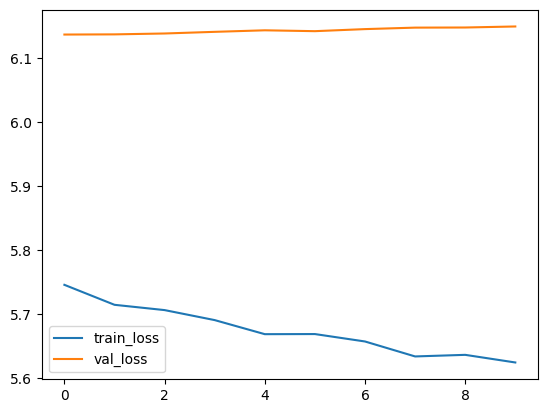

In [47]:
# Plot train and valid loss 
plt.plot(trainingEpoch_loss, label='train_loss')
plt.plot(validationEpoch_loss,label='val_loss')
plt.legend()
plt.show

In [35]:
test_loss = evaluate_func(model, test_data_loader, criterion)

print(f"| Test Loss: {test_loss:.3f} | Test PPL: {np.exp(test_loss):7.3f} |")

| Test Loss: 5.956 | Test PPL: 385.884 |


### Translation 

In [36]:
"""
translate the sentences in test dataset from informal to formal Japanese.

    Sentence > Data Preprocessng > Tokenization > Normalization > Encoder > Decoder >
    1. Data Preprocessing: clean the sentence data
    2. Normalization     : eliminate unhelpful information in sentence.
    3. Tokenization      : turn the sentence into tokens
    4. Numericalization  : turn tokens into ids then into tensor
    5. Encoder           : provides the initial hidden state for Decoder
    6. Decoder           : pass tensor into decoder to predict targeted output

"""
def translation(source_sentence, model, src_vocab, trg_vocab, dataset, max_length=20):
    print("\n'''''''''''''''''''''''''''''''''''''")
    print("source sentence:", source_sentence)
    model.eval()
    with torch.no_grad():
        # Data Preprocessing
        cleaned_sentence = data_cleaning(source_sentence)
        # Normalization
        preprocessed_sentence = normalization(cleaned_sentence)
        # Tokenization + Numericalization
        src_token = src_vocab.lookup_indices([sos_token]) + dataset.numericalized(preprocessed_sentence, src_vocab) + src_vocab.lookup_indices([eos_token])
        # src_token = src_vocab.lookup_indices([sos_token]) + src_vocab.lookup_indices(tokenization(preprocessed_sentence)) + src_vocab.lookup_indices([eos_token])

        print(src_token)
        src_display(src_token) # type of src_token = list of int indices 

        # Encoder
        # tensor = torch.LongTensor(src_token).unsqueeze(-1)
        tensor = torch.tensor(src_token).unsqueeze(-1)
        print("\nencoder tensor:", tensor)
        hidden, cell = model.encoder(tensor)
        # print("\nhidden", hidden)
        # print("\ncell", cell)

        predicted_sentence_index = trg_vocab.lookup_indices([sos_token]) # store indices
        # print("initial:", predicted_sentence_index)
        predicted_sentence_string = [] # store tokens 

        # Decoder
        for i in range(max_length):
            print([predicted_sentence_index[-1]])

            # src_tensor = torch.LongTensor([predicted_sentence_index[-1]])
            src_tensor = torch.tensor([predicted_sentence_index[-1]])
            output, hidden, cell = model.decoder(src_tensor, hidden, cell)
            predicted_token = output.argmax(-1).item()
            predicted_sentence_index.append(predicted_token)
            predicted_sentence_string.append(trg_vocab.get_itos()[predicted_token])

            if predicted_token == trg_vocab[eos_token]:
                break

    return predicted_sentence_string

In [49]:
'''
Evaluation: testing from informal to formal Japanese
'''
sentence = "JR京都駅に到着した湖西線の列車内に不審物があると、駅員から通報があっだ"
sentence_2 = "京都駅を発着する列車の運転を1時間半くらいにわたって見合わせた"
sentence_3 = "でもそのイベントの前からチッソ株式会社は継続的に汚染していた"
sentence_4 = "週末街に出た"
sentence_4_trg = "週末街に出てきました"
sentence_5 = "週末"

predicted_sentence = translation(sentence, model, train_X_vocab, train_y_vocab, train_dataset)
print("\n\npredicted_sentence:", predicted_sentence)

predicted_sentence = translation(sentence_2, model, train_X_vocab, train_y_vocab, train_dataset)
print("\n\npredicted_sentence:", predicted_sentence)

predicted_sentence = translation(sentence_3, model, train_X_vocab, train_y_vocab, train_dataset)
print("\n\npredicted_sentence:", predicted_sentence)

predicted_sentence = translation(sentence_4, model, train_X_vocab, train_y_vocab, train_dataset)
print("\n\npredicted_sentence:", predicted_sentence)

predicted_sentence = translation(sentence_5, model, train_X_vocab, train_y_vocab, train_dataset)
print("\n\npredicted_sentence:", predicted_sentence)



'''''''''''''''''''''''''''''''''''''
source sentence: JR京都駅に到着した湖西線の列車内に不審物があると、駅員から通報があっだ
[2, 0, 0, 2104, 5, 0, 13, 8, 0, 0, 4, 1641, 905, 5, 0, 337, 9, 42, 11, 0, 23, 0, 9, 153, 27, 3]

src (indice -> word): <sos> <unk> <unk> 駅 に <unk> し た <unk> <unk> の 列車 内 に <unk> 物 が ある と <unk> から <unk> が あっ だ <eos> 
encoder tensor: tensor([[   2],
        [   0],
        [   0],
        [2104],
        [   5],
        [   0],
        [  13],
        [   8],
        [   0],
        [   0],
        [   4],
        [1641],
        [ 905],
        [   5],
        [   0],
        [ 337],
        [   9],
        [  42],
        [  11],
        [   0],
        [  23],
        [   0],
        [   9],
        [ 153],
        [  27],
        [   3]])
[2]
[4]
[4]
[4]
[6]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[8]
[8]
[8]
[8]
[8]
[8]


predicted_sentence: ['の', 'の', 'の', 'は', 'の', 'の', 'の', 'の', 'の', 'の', 'の', 'の', 'の', 'た', 'た', 'た', 'た', 'た', 'た', 'た']

'''''''''''''''''''''''''''''''''''''
source sentence:

In [52]:
# Prepare translation for test data
translations = []

for i in range(len(X_test)):
    predicted_translation = translation(X_test[i], model, train_X_vocab, train_y_vocab, train_dataset)
    translations.append(predicted_translation)



'''''''''''''''''''''''''''''''''''''
source sentence: 今日は午前９時に大学へ行こうとしたが、家の近くの道路が、工事中のため通行止めでした。
[2, 97, 6, 1656, 32, 49, 5, 263, 141, 623, 11, 13, 8, 9, 186, 4, 2049, 4, 1252, 9, 1749, 45, 4, 82, 2060, 1863, 46, 8, 3]

src (indice -> word): <sos> 今日 は 午前 0 時 に 大学 へ 行こう と し た が 家 の 近く の 道路 が 工事 中 の ため 通行 止め でし た <eos> 
encoder tensor: tensor([[   2],
        [  97],
        [   6],
        [1656],
        [  32],
        [  49],
        [   5],
        [ 263],
        [ 141],
        [ 623],
        [  11],
        [  13],
        [   8],
        [   9],
        [ 186],
        [   4],
        [2049],
        [   4],
        [1252],
        [   9],
        [1749],
        [  45],
        [   4],
        [  82],
        [2060],
        [1863],
        [  46],
        [   8],
        [   3]])
[2]
[4]
[4]
[4]
[6]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[8]
[8]
[8]
[8]
[8]

'''''''''''''''''''''''''''''''''''''
source sentence: ちなみに、台湾の人気ウェブは"台灣論壇"や"台大PTT(BBS)"です。
[2, 363, 5, 546, 4, 148

In [51]:
# Tokenize target sentences
tokenized_trg_sentence = []

for data in y_test:
    cleaned_data = data_cleaning(data)
    normalized_data = normalization(cleaned_data)
    tokens = tokenization(normalized_data)
    tokenized_trg_sentence.append(tokens)
    

In [53]:
# # Show an example of source sentence, model-generated translation, and target sentence. 
print("Source Sentence :", X_test[0])
print("\nModel Prediction:", translations[0])
print("\nTarget Sentence :", tokenized_trg_sentence[0])

# print(translations)
# print(tokenized_trg_sentence)


Source Sentence : 今日は午前９時に大学へ行こうとしたが、家の近くの道路が、工事中のため通行止めでした。

Model Prediction: ['の', 'の', 'の', 'は', 'の', 'の', 'の', 'の', 'の', 'の', 'の', 'の', 'の', 'の', 'た', 'た', 'た', 'た', 'た', 'た']

Target Sentence : ['今日', 'は', '午前', '0', '時', 'に', '大学', 'へ', '行こう', 'と', 'し', 'まし', 'た', 'が', '家', 'の', '近く', 'の', '道路', 'が', '工事', '中', 'の', 'ため', '通行', '止め', 'でし', 'た']


## Conclusion 
This project **does *NOT* give a functional translation currently**. The translation function keeps generating the same few words at index 4, 6, and 8. Definitely a part of the model is incorrect. I have tried to see the input I am putting in for model, but everything looks good. This will require more time and effort to look into it. 

Besides the existing issues, I am looking into invesigating these parts to have this model improve its result in the future. 
* **Increase Dataset (Parallel Corpus)**: the suggested dataset needed is from 1,000 - 10,000. My dataset only has around ~850 pairs. Increasing the dataset will improve the training for sure.
* **Try Various Combination of Variables**: different combincation of batch, hidden dimension, and embedding dimension can be tested to see which one gives out better results.